In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


Import all the libraries needed.

In [2]:
import gc
import os
import time
import random
import datetime
import warnings

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

Read the data...

In [3]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [4]:
print(f'Train: rows:{train.shape[0]} cols:{train.shape[1]}')

Train: rows:629145480 cols:2


How to proceed:
1. plot the data in 2 ways: full data and data with intervals(small section)
2. check if any seasonaliy, trend and noise is there or not/
3. we have signal value and time to failure so check if ARIMA is suitable or not(bcz we don't have regular time stamp)
4. like stock prices dataset, stock price == time to failure, dates given == signal value according to signal variation we have to predict that how much time is remaining for earthquake for a given signal. and finally calculate MSE(mean squared error) using observed value and predicted value.

First do the data analysis properly

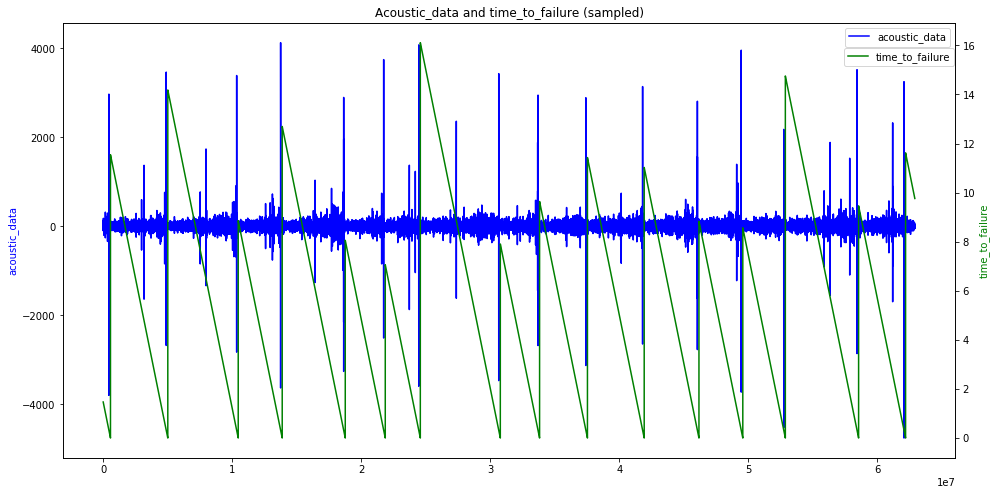

In [5]:
train_acoustic_data_small = train['acoustic_data'].values[::10]
train_time_to_failure_small = train['time_to_failure'].values[::10]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Acoustic_data and time_to_failure (sampled)')
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

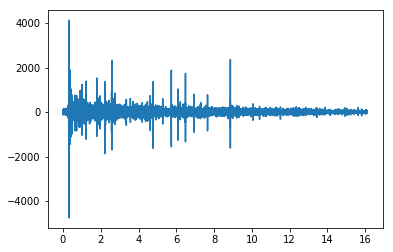

In [6]:
plt.plot(train_time_to_failure_small,train_acoustic_data_small)

In [7]:
from sklearn.linear_model import LinearRegression
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [8]:
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data']   # pd series
    y = seg['time_to_failure'].values[-1]  # single value
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.values.mean()
    X_train.loc[segment, 'std'] = x.values.std()
    X_train.loc[segment, 'max'] = x.values.max()
    X_train.loc[segment, 'min'] = x.values.min()
    X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
    X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
    X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
    X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
    X_train.loc[segment, 'trend'] = add_trend_feature(x.values)
    X_train.loc[segment, 'abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
        X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        
        X_train.loc[segment, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_train.loc[segment, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_train.loc[segment, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_train.loc[segment, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_train.loc[segment, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_train.loc[segment, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_train.loc[segment, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_train.loc[segment, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)


100%|██████████| 4194/4194 [16:11<00:00,  4.39it/s]


In [9]:
print("Train shape:", X_train.shape)
X_train.head()

Train shape: (4194, 115)


,ave,std,max,min,q90,q95,q99,q05,q10,q01,abs_max,abs_mean,abs_std,trend,abs_trend,ave_roll_std_10,std_roll_std_10,max_roll_std_10,min_roll_std_10,q01_roll_std_10,q05_roll_std_10,q10_roll_std_10,q95_roll_std_10,q99_roll_std_10,ave_roll_mean_10,std_roll_mean_10,max_roll_mean_10,min_roll_mean_10,q01_roll_mean_10,q05_roll_mean_10,q95_roll_mean_10,q99_roll_mean_10,ave_roll_abs_mean_10,std_roll_abs_mean_10,max_roll_abs_mean_10,min_roll_abs_mean_10,q01_roll_abs_mean_10,q05_roll_abs_mean_10,q95_roll_abs_mean_10,q99_roll_abs_mean_10,...,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,ave_roll_abs_mean_100,std_roll_abs_mean_100,max_roll_abs_mean_100,min_roll_abs_mean_100,q01_roll_abs_mean_100,q05_roll_abs_mean_100,q95_roll_abs_mean_100,q99_roll_abs_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q10_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,ave_roll_abs_mean_1000,std_roll_abs_mean_1000,max_roll_abs_mean_1000,min_roll_abs_mean_1000,q01_roll_abs_mean_1000,q05_roll_abs_mean_1000,q95_roll_abs_mean_1000,q99_roll_abs_mean_1000
0,4.884113,5.101089,104.0,-98.0,10.0,11.0,18.0,-2.0,0.0,-8.0,104.0,5.576567,4.333310,-3.268300e-06,-0.000011,3.507118,2.809071,78.313047,0.421637,1.264911,1.636392,1.873796,7.226494,15.034220,4.884088,2.801800,68.5,-60.0,-2.40,1.7,8.1,12.40,5.576566,2.897799,68.5,0.9,2.3,3.0,9.2,16.6,...,0.452294,10.04,1.04,3.81,4.16,5.58,5.95,5.576655,2.193084,44.73,3.60,4.15,4.42,7.83,14.54,4.288590,2.769772,31.029445,2.536633,2.616094,2.706474,2.770139,8.185756,15.055998,4.883418,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,5.579118,1.612370,24.851,4.110,4.340,4.589,7.518,11.487
1,4.725767,6.588802,181.0,-154.0,10.0,12.0,21.0,-2.0,0.0,-11.0,181.0,5.734167,5.732758,9.090424e-07,-0.000005,3.761435,4.120785,122.978273,0.421637,1.286684,1.646545,1.873796,8.265726,18.772705,4.725732,3.924070,145.1,-128.0,-4.60,1.2,8.2,13.80,5.734187,4.403190,145.1,0.6,2.3,3.0,9.9,21.1,...,0.496220,16.67,-4.09,3.64,4.05,5.39,5.75,5.734653,3.563252,77.30,3.61,4.11,4.35,8.85,19.29,4.843486,4.492905,38.643217,2.509453,2.612482,2.674879,2.729840,10.544982,33.704332,4.724876,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,5.739510,2.399157,28.410,4.325,4.447,4.552,8.552,20.504
2,4.906393,6.967374,140.0,-106.0,10.0,13.0,26.0,-3.0,0.0,-15.0,140.0,6.152647,5.895925,3.962182e-06,0.000010,4.080841,4.227960,96.247424,0.516398,1.316561,1.686548,1.911951,10.211649,23.865014,4.906229,4.179729,94.8,-72.9,-7.31,0.8,9.1,17.00,6.152557,4.429093,94.8,0.7,2.3,3.0,12.1,26.1,...,0.530151,12.38,-1.55,3.65,4.14,5.66,6.26,6.153045,3.516817,45.40,3.59,4.22,4.50,11.55,23.81,5.423013,4.402140,35.326896,2.584105,2.660178,2.761534,2.829290,14.845834,23.928873,4.905840,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,6.159850,2.414414,26.940,4.394,4.513,4.717,10.959,16.539
3,4.902240,6.922282,197.0,-199.0,10.0,12.0,22.0,-2.0,0.0,-12.0,199.0,5.933960,6.061193,1.637207e-06,-0.000002,3.788192,4.284176,141.450580,0.516398,1.269296,1.649916,1.888562,8.380533,19.249384,4.902291,4.299460,125.3,-136.6,-5.10,1.3,8.5,14.80,5.933982,4.692604,136.6,0.8,2.3,3.0,10.3,23.3,...,0.581874,18.26,-9.37,3.76,4.16,5.61,6.09,5.934187,3.913703,91.32,3.82,4.21,4.47,9.34,21.43,4.939280,4.873523,52.805653,2.524149,2.624962,2.716991,2.773216,11.715642,21.950987,4.901486,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,5.939037,2.782407,38.653,4.393,4.514,4.658,9.091,16.770
4,4.908720,7.301086,145.0,-126.0,10.0,12.0,26.0,-2.0,0.0,-15.0,145.0,6.110587,6.329464,-6.668392e-07,0.000005,3.835604,4.183253,99.647657,0.516398,1.269296,1.646545,1.885618,8.547904,23.109353,4.908728,4.931291,107.6,-85.4,-9.00,1.1,8.8,19.01,6.110644,4.968916,107.6,0.8,2.3,3.0,11.2,29.8,...,0.566267,14.41,-1.97,3.59,4.21,5.63,6.48,6.111666,4.066011,64.29

In [10]:
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
target = y_train.values.flatten()


In [11]:
import keras 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

classifier = svm.SVR() # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)
classifier.fit(X_train_scaled, y_train) # Then we train our model, with our balanced data train.
prediction_SVM_all = classifier.predict(X_train_scaled) #And finally, we predict our data test.
Score = mean_absolute_error(target, prediction_SVM_all)
print(f'Score: {Score:0.3f}')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 1.964


In [12]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [13]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data']  # pd series
    
    X_test.loc[seg_id, 'ave'] = x.values.mean()
    X_test.loc[seg_id, 'std'] = x.values.std()
    X_test.loc[seg_id, 'max'] = x.values.max()
    X_test.loc[seg_id, 'min'] = x.values.min()
    X_test.loc[seg_id, 'q90'] = np.quantile(x.values, 0.90)
    X_test.loc[seg_id, 'q95'] = np.quantile(x.values, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x.values, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x.values, 0.05)
    X_test.loc[seg_id, 'q10'] = np.quantile(x.values, 0.10)
    X_test.loc[seg_id, 'q01'] = np.quantile(x.values, 0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x.values).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x.values).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x.values).std()
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x.values)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(w)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_test.loc[seg_id, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        
        X_test.loc[seg_id, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_test.loc[seg_id, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_test.loc[seg_id, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_test.loc[seg_id, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_test.loc[seg_id, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

In [14]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled)

[[-0.1081212  -0.19460464 -0.17788929 ... -0.19571921 -0.32816727
  -0.19426264]
 [-1.36033181 -0.07358216 -0.04232056 ... -1.1874441  -0.04217907
  -0.04079925]
 [ 0.35460361  0.04685245  0.30942533 ...  0.2699603  -0.13355289
   0.0516932 ]
 ...
 [-3.01067009  0.34325463  0.53659455 ... -2.29990072  0.23716377
   0.18943468]
 [-0.69431219  0.78209681  0.72712357 ...  0.16647596  2.22626512
   0.48302245]
 [-1.24876441 -0.34988847 -0.33177812 ... -1.31248768 -0.79571645
  -0.23927857]]


In [15]:

submission['time_to_failure'] = classifier.predict(X_test_scaled)
submission.to_csv('submission.csv')